In [1]:
import pandas as pd
import numpy as np
import re
import json
import os
import hashlib
import random
from datetime import datetime
import requests
from PIL import Image, ImageDraw

# matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Ellipse
import matplotlib.gridspec as gridspec
import matplotlib.font_manager as fm

In [2]:
streaming_data = pd.read_csv('output/streaming_history.csv')

streaming_data['ts'] = pd.to_datetime(streaming_data['ts'])

## <span style="color: #95a5a6">Get Top N Data</span>

In [3]:
variable = 'artist_name' # change to album_name to show top albums
date = 'y' # year column
top_n = 15

In [4]:
streaming_timeseries = streaming_data.groupby([date, variable], as_index=False)['minutes_played'].sum()

streaming_timeseries['rank'] = streaming_timeseries.groupby([date])['minutes_played'].rank('dense', ascending=False)

top_streaming = streaming_timeseries[streaming_timeseries['rank'] <= top_n].reset_index(drop=True)
unique_names = top_streaming[variable].unique().tolist()

## <span style="color: #95a5a6">Use Spotify API to get Artists Image for Top N (Optional)</span>

#### <span style="color: #95a5a6">Set up API Credentials</span>

In [5]:
client_id = ''
client_secret = ''
auth_url = 'https://accounts.spotify.com/api/token'
auth_response = requests.post(auth_url, {
    'grant_type': 'client_credentials',
    'client_id': client_id,
    'client_secret': client_secret,
})
auth_response_data = auth_response.json()
access_token = auth_response_data['access_token']
# define headers using access token
headers = {
    'Authorization': f'Bearer {access_token}'
}

#### <span style="color: #95a5a6">Get a song ID for each artist in the Top N</span>

In [5]:
unique_artist_rows = streaming_data[streaming_data['artist_name'].isin(unique_names)].drop_duplicates('artist_name')
# remove any artists where image already gathered
existing_images = [x.replace('.png', '') for x in os.listdir('images/cropped') if '.png' in x]
no_image_required = unique_artist_rows[unique_artist_rows['artist_name'].isin(existing_images)]
unique_artist_rows.drop(index=no_image_required.index, inplace=True)
unique_artist_track_ids = unique_artist_rows['track_id'].tolist()

#### <span style="color: #95a5a6">Query the song IDs to get Artist ID</span>

In [30]:
# define endopint
url = f"https://api.spotify.com/v1/tracks?"
# loop over chunks of 50 track ids
track_json = []
for start in range(0, len(unique_artist_track_ids), 50):
    end = start+50
    print(start, start+50)
    chunk_ids = unique_artist_track_ids[start:end]
    params = {'ids':','.join(chunk_ids)}
    # get artist data
    response = requests.get(url, params=params, headers=headers)
    json_content = response.json()
    track_json.extend(json_content['tracks'])
# process track info to get artist ids
primary_artist_ids = pd.json_normalize(pd.json_normalize(pd.DataFrame(track_json)['artists'])[0])[['name', 'id']].apply(tuple, axis=1).tolist()

0 50


#### <span style="color: #95a5a6">Query the artist ID to get their PFP Image URL</span>

In [31]:
# define endopint
url = f"https://api.spotify.com/v1/artists?"
# loop over chunks of 50 track ids
artist_json = []
for start in range(0, len(primary_artist_ids), 50):
    end = start+50
    print(start, start+50)
    chunk_ids = [x[1] for x in primary_artist_ids[start:end]]
    params = {'ids':','.join(chunk_ids)}
    # get artist data
    response = requests.get(url, params=params, headers=headers)
    json_content = response.json()
    artist_json.extend(json_content['artists'])
# process artist data getting image url
artist_images = pd.concat([pd.DataFrame(artist_json)['name'], pd.json_normalize(pd.DataFrame(artist_json)['images'])[2].apply(lambda x: x.get('url'))], axis=1)

0 50


#### <span style="color: #95a5a6">Download the images</span>

In [32]:
# function to download and save image
def download_image(url, image_name):
    response = requests.get(url)
    with open(f'images/{image_name}', 'wb') as f:
        f.write(response.content)
            
# iterate through the list of URLs
for i, row in artist_images.iterrows():
    # Get the image filename from the URL
    image_name = row['name'] + '.jpg'
    # Download and save the image
    download_image(url=row[2], image_name=image_name)

#### <span style="color: #95a5a6">Crop the images to a circle</span>

In [37]:
def crop_image_to_circle(image_path, output_path, size=(200, 200)):
    # Open the image
    img = Image.open(f'images/{image_path}')
    # Resize the image to the desired size (optional, based on your requirement)
    img = img.resize(size, Image.ANTIALIAS)
    # Create a mask (circle) with a white background
    mask = Image.new("L", size, 0)  # "L" mode for grayscale, 0 means black (transparent)
    draw = ImageDraw.Draw(mask)
    draw.ellipse((0, 0, size[0], size[1]), fill=255)  # Draw a white circle in the center
    # Apply the mask to the image
    img.putalpha(mask)  # Apply the circular mask to the image
    # Save the final image as PNG with a transparent background
    img.save(output_path, format="PNG")

for name in unique_artist_rows['artist_name'].tolist():
    input_image = f'{name}.jpg'  # Path to the input image
    output_image = f'images/cropped/{name}.png'  # Path to save the cropped image
    crop_image_to_circle(input_image, output_image)

C:\Users\Hieye\AppData\Local\Temp\ipykernel_14216\2452864275.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize(size, Image.ANTIALIAS)


## <span style="color: #95a5a6">Bump Chart</span>

#### <span style="color: #95a5a6">Set up helper functions</span>

In [7]:
def sigmoid_curve(x, x0, x1, y0, y1, num_points=100):
    t = np.linspace(-18, 18, num_points)  # Spread sigmoid over range
    sigmoid = 1 / (1 + np.exp(-t))      # Sigmoid shape
    x_vals = np.linspace(x0, x1, num_points)
    y_vals = y0 + (y1 - y0) * sigmoid   # Scale sigmoid between y0 and y1
    return x_vals, y_vals

In [8]:
def ordinal(n: int):
    if 11 <= (n % 100) <= 13:
        suffix = 'th'
    else:
        suffix = ['th', 'st', 'nd', 'rd', 'th'][min(n % 10, 4)]
    return str(n) + suffix

#### <span style="color: #95a5a6">Load a dictionary of colours for the selected variable</span>

In [9]:
# load generic set of colours
with open("resources/colour_set.txt", 'r') as f:
        colour_set = f.read().split('\n')

# read a colour dictionary if exists
try:
    with open(f"resources/{variable}_colours.json", 'r', encoding='utf-8') as f:
        colour_dict = json.load(f)
except:
    colour_dict = {}

# account for unmapped names
randomised = []
for name in unique_names:
    if name not in colour_dict:
        colour_dict[name] = colour_set[random.randint(0, (len(colour_set)-1))]
        randomised.append(name)
print(f'No colour dictionary available for some names: {randomised}')

No colour dictionary available for some names: ['Bob Marley & The Wailers', 'C418']


#### <span style="color: #95a5a6">Set up fonts</span>

In [10]:
font_title = fm.FontProperties(fname='resources/Poppins-Medium.ttf', size=31)
font_large = fm.FontProperties(fname='resources/Roboto-Medium.ttf', size=12)
font_med = fm.FontProperties(fname='resources/Roboto-Medium.ttf', size=10)
font_small = fm.FontProperties(fname='resources/Roboto-Medium.ttf', size=9)
font_years = fm.FontProperties(fname='resources/Roboto-Bold.ttf', size=14)

#### <span style="color: #95a5a6">Create chart</span>

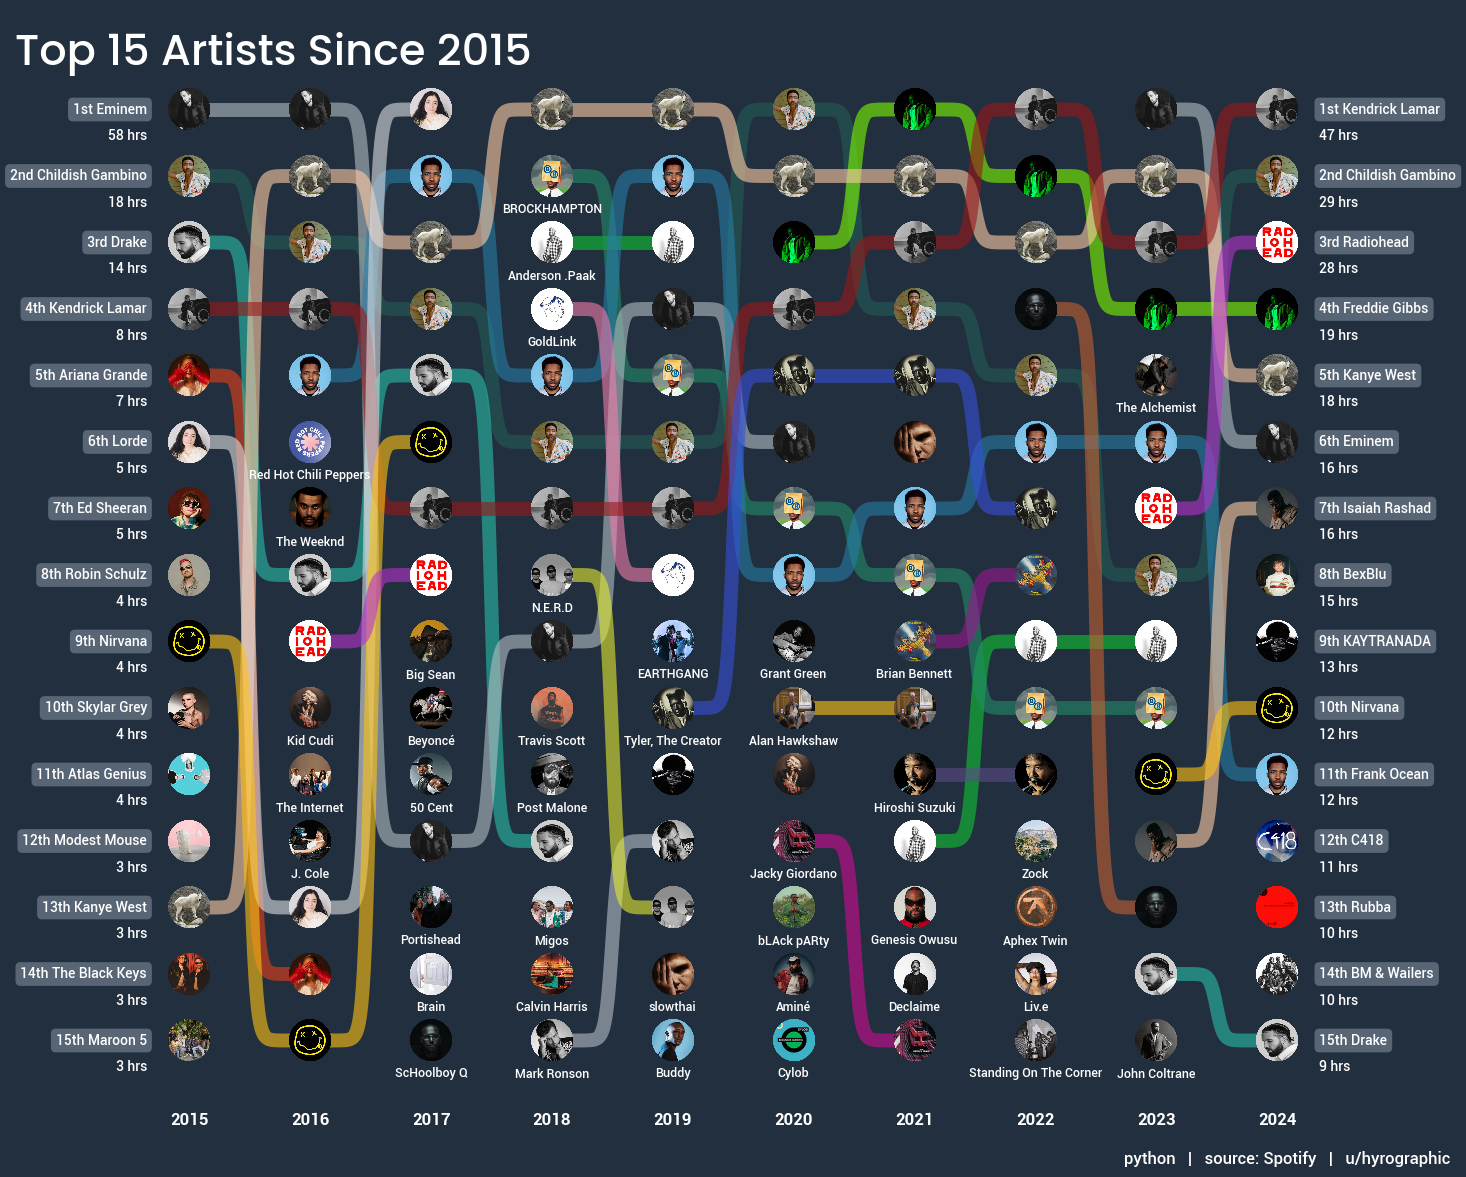

In [13]:
fig = plt.figure(figsize=(17,0.95*top_n), facecolor = "#222f3e")

gs = gridspec.GridSpec(1, 2, width_ratios=[0.001, 1])  # The second subplot will be twice as wide

# Add subplots using the GridSpec layout
ax1 = fig.add_subplot(gs[0])  # Left subplot
ax2 = fig.add_subplot(gs[1])  # Right subplot

# AX1
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_facecolor('#222f3e')

# AX2
# set title
ax2.annotate(f'Top 15 Artists Since 2015', xy=(2014.6, 14), xytext=(-0.1, 0.95), textcoords='axes fraction', ha= "left", color= 'w', fontproperties=font_title)

# set background
ax2.set_facecolor('#222f3e')

# set axis limits
plt.ylim(-1, top_n+0.5)
# ax2.set_xlim(2015, 2024)

# remove y axis labels
ax2.yaxis.set_ticks([])

# remove chart border
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# year labels
ax2.set_xticks(streaming_data['y'].unique())
ax2.set_xticklabels(streaming_data['y'].unique(), fontproperties=font_years)
ax2.tick_params(axis='x', labelsize=12, labelcolor='w', direction='in', color='#222f3e')

# plot lines and images
for name, variable_data in top_streaming.groupby(variable):
    colour = colour_dict.get(name, '#FFFFFF')
    # loop through x and y values and apply sigmoid curve
    x = variable_data['y'].values
    y = top_n - variable_data['rank'].values
    for i in range(len(x) - 1):
        x0, x1 = x[i], x[i + 1]
        y0, y1 = y[i], y[i + 1]
        # don't draw lines where years are non consecutive
        if (x1 - x0) > 1:
            continue
        curve_x, curve_y = sigmoid_curve(x, x0, x1, y0, y1)
        ax2.plot(curve_x, curve_y, linewidth=10, color=colour, alpha=0.6, zorder=0)
    # plot images or circles if images don't exist
    try:
        img = plt.imread(f'images/cropped/{name}.png')
        for x, y in zip(variable_data['y'], top_n - variable_data['rank']):
            # add image to plot
            imagebox = OffsetImage(img, zoom=0.15)
            ab = AnnotationBbox(imagebox, (x, y), frameon=False, zorder=2)
            ax2.add_artist(ab)
    except:
        # plot circles (instead of images)
        ax2.plot(variable_data['y'], top_n-variable_data['rank'], 'o', markersize=25, color=colour, zorder=1)
    
# add name legend at the start bar only 
offset_text_start = top_streaming['y'].min() - 0.35
first_year_top_15 = top_streaming[(top_streaming['y']==top_streaming['y'].min())].sort_values('rank').reset_index()
for i, row in first_year_top_15.iterrows():
    name = row[variable]
    y = int(row['rank']) 
    colour = colour_dict.get(name)
    annotation = str(ordinal(y)) + ' ' + name
    minutes = str(round(row['minutes_played'] / 60)) + ' hrs'
    ax2.annotate(annotation, (offset_text_start, top_n-y),
                ha= "right",
                va="center",
                color= 'w',
                annotation_clip=False,
                fontproperties=font_med,
                bbox=dict(facecolor='#576574', edgecolor='#576574', boxstyle='round,pad=0.3')
               )
    ax2.annotate(minutes, (offset_text_start, top_n-0.4-y),
                ha= "right",
                va="center",
                color= 'w',
                annotation_clip=False,
                fontproperties=font_med
               )
    
# # add name legend at the end bar only 
offset_text_end = top_streaming['y'].max() + 0.35
latest_year_top_15 = top_streaming[(top_streaming['y']==top_streaming['y'].max())].sort_values('rank').reset_index()
for i, row in latest_year_top_15.iterrows():
    name = row[variable]
    y = int(row['rank']) 
    colour = colour_dict.get(name)
    annotation = str(ordinal(y)) + ' ' + name.replace('Bob Marley & The Wailers', 'BM & Wailers')
    minutes = str(round(row['minutes_played'] / 60)) + ' hrs'
    ax2.annotate(annotation, (offset_text_end, top_n-y),
                ha= "left",
                va="center",
                color= 'w',
                annotation_clip=False,
                fontproperties=font_med,
                bbox=dict(facecolor='#576574', edgecolor='#576574', boxstyle='round,pad=0.3')
               )
    ax2.annotate(minutes, (offset_text_end, top_n-0.4-y),
                ha= "left",
                va="center",
                color= 'w',
                annotation_clip=False,
                fontproperties=font_med
               )

# add name legend for middle artists
exclude_first = ~top_streaming[variable].isin(latest_year_top_15[variable].tolist())
exclude_last = ~top_streaming[variable].isin(first_year_top_15[variable].tolist())
middle_artists = top_streaming[exclude_first & exclude_last].sort_values('y').reset_index()
middle_artists.drop_duplicates([variable], keep='first', inplace=True)

for i, row in middle_artists.iterrows():
    name = row[variable].replace('鈴木 弘', 'Hiroshi Suzuki')
    x = int(row['y'])
    y = int(row['rank'])
    # name_annotation = name if len(name) < 18 else name[:18]+ '...'
    ax2.annotate(name, (x, top_n-0.5-y),
                ha= "center",
                va="center",
                color= 'w',
                annotation_clip=False,
                fontproperties=font_small)

# add footer
fig.text(0.97, 0.07, 'python   |   source: Spotify   |   u/hyrographic', fontproperties=font_small, fontsize=12, color='w', ha='right')

image_path = f'output/charts/Top {top_n} {variable} Over Time {datetime.today().strftime("%b%d-%H%p")}.png'
# plt.savefig(image_path, dpi=500, bbox_inches='tight')